In [ ]:
!rm -r sample_data
!sudo apt install -q -y aria2

!aria2c -x 10 -j 5 --show-console-readout true --summary-interval 10 http://images.cocodataset.org/zips/train2017.zip
!unzip -q train2017.zip
!rm -r train2017.zip

!aria2c -x 10 -j 5 --show-console-readout true --summary-interval 10 http://images.cocodataset.org/zips/test2017.zip
!unzip -q test2017.zip
!rm -r test2017.zip

!aria2c -x 10 -j 5 --show-console-readout true --summary-interval 10 http://images.cocodataset.org/zips/val2017.zip
!unzip -q val2017.zip
!rm -r val2017.zip

!pip install tqdm

In [ ]:
!rm train2017/000000568405.jpg

In [ ]:
import numpy as np
from IPython.display import display
import os, random
from tqdm.notebook import tqdm
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.image import resize
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Activation, Add, BatchNormalization, Dense, Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19

In [ ]:
print(len(os.listdir('train2017')), len(os.listdir('val2017')), len(os.listdir('test2017')))

In [ ]:
class dataGen(Sequence):
    def __init__(self, images, batch_size):
        self.images = images
        self.batch_size = batch_size

    def __len__(self):
        return int(len(self.images) / self.batch_size)

    def __getitem__(self, idx):
        images = self.images[idx*self.batch_size:(idx+1)*self.batch_size]
        images = np.array([img_to_array(load_img(img)) for img in images])

        x = [img.shape[0] - 64 for img in images]
        y = [img.shape[1] - 64 for img in images]

        x = [random.randint(0, i) if i >= 0 else -1 for i in x]
        y = [random.randint(0, i) if i >= 0 else -1 for i in y]

        images = [[line[y[i]:y[i]+64] for line in images[i][x[i]:x[i]+64]] if y[i] >= 0 and x[i] >= 0 else np.random.rand(64,64,3)*255 for i in range(self.batch_size)]
        
        x = np.array(images)
        x = np.array(resize(x, (32, 32))) / 255
        y = np.array(images) / 255

        return x, y

In [ ]:
train = os.listdir('train2017')
train = ['train2017/' + img for img in train]
train = dataGen(train, 8)

val = os.listdir('val2017')
val = ['val2017/' + img for img in val]
val = dataGen(val, 8)

test = os.listdir('test2017')
test = ['test2017/' + img for img in test]
test = dataGen(test, 8)

In [ ]:
x, y = train[0]
x, y = x * 255, y * 255
print(x.shape, y.shape)

i = 5

a = array_to_img(x[i]).resize((256,256))
b = array_to_img(y[i]).resize((256,256))

display(a)
display(b)

In [ ]:
def ResidualBlock(inputs, filters):
    x = Conv2D(filters, (3,3), strides=1, padding='same')(inputs)
    x = Activation('relu')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(filters, (3,3), strides=1, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Add()([x, inputs])
    return x

def DeConv2D(inputs):
    x = UpSampling2D(size=2)(inputs)
    x = Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
    x = Activation('relu')(x)
    return x

In [ ]:
inputs = Input(shape=(None,None,3))
inner = inputs
inner1 = Conv2D(64, (9,9), strides=1, padding='same')(inner)
inner1 = Activation('relu')(inner1)

inner = inner1
inner = ResidualBlock(inner, 64)

for _ in range(15):
    inner = ResidualBlock(inner, 64)

inner = Conv2D(64, (3,3), strides=1, padding='same')(inner)
inner = BatchNormalization(momentum=0.8)(inner)
inner = Add()([inner, inner1])

inner = DeConv2D(inner)

outputs = Conv2D(3, (9,9), strides=1, padding='same', activation='sigmoid')(inner)

generator = Model(inputs=inputs, outputs=outputs)

generator.compile(loss='mse', optimizer='Adam')

generator.summary()

In [ ]:
generator = load_model('generator.h5')

In [ ]:
def DBlock(inputs, filters, strides=1, bn=True):
    x = Conv2D(filters, (3,3), strides=strides, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    if bn:
        x = BatchNormalization(momentum=0.8)(x)
    
    return x

In [ ]:
inputs = Input(shape=(64,64,3))
inner = inputs

inner = DBlock(inner, 64, bn=False)
inner = DBlock(inner, 64, strides=2)
inner = DBlock(inner, 128)
inner = DBlock(inner, 128, strides=2)
inner = DBlock(inner, 256)
inner = DBlock(inner, 256, strides=2)
inner = DBlock(inner, 512)
inner = DBlock(inner, 512, strides=2)

inner = Flatten()(inner)

inner = Dense(1024)(inner)
inner = LeakyReLU(alpha=0.2)(inner)

outputs = Dense(1, activation='sigmoid')(inner)

discriminator = Model(inputs=inputs, outputs=outputs)

discriminator.compile(loss='binary_crossentropy', optimizer='Adam')

discriminator.summary()

In [ ]:
discriminator = load_model('discriminator.h5')

In [ ]:
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(64,64,3))
vgg = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)

inputs = Input(shape=(64,64,3))
outputs = vgg(inputs)

vgg = Model(inputs=inputs, outputs=outputs)

vgg.compile(loss='mse', optimizer='Adam')

vgg.summary()

In [ ]:
vgg = load_model('vgg.h5')

In [ ]:
inputs_lr = Input(shape=(None,None,3))

fake_hr = generator(inputs_lr)

discriminator.trainable = False
validity = discriminator(fake_hr)

vgg.trainable = False
features = vgg(fake_hr)

combined = Model(inputs=inputs_lr, outputs=[validity, features, fake_hr])

combined.compile(loss=['binary_crossentropy', 'mse', 'mse'], loss_weights=[1e-3, 1e0, 6e-1], optimizer='Adam')

In [ ]:
# pretrain generator
generator.fit(train, steps_per_epoch=len(train), epochs=1, validation_data=(val), validation_steps=len(val), verbose=1, workers=10)
generator.save('generator.h5')

In [ ]:
# pretrain discriminator
discriminator_loss = 1

for epoch in range(1):
    batches = len(train)
    bar = tqdm(range(batches), desc='epoch ' + str(epoch), leave=True)

    for batch in bar:
        imgs_lr, imgs_hr = train[batch]

        fake_hr = np.array(generator.predict(imgs_lr))

        valid = np.ones((train.batch_size, 1))
        fake = np.zeros((train.batch_size, 1))

        x = np.concatenate((imgs_hr, fake_hr), axis=0)
        y = np.concatenate((valid, fake), axis=0)

        discriminator_loss = 0.5 * (discriminator.train_on_batch(x, y) + discriminator_loss)

        bar.set_postfix(discriminator_loss=str(discriminator_loss))

    discriminator.save('discriminator.h5')


In [ ]:
discriminator_loss = 1
generator_loss = 1

for epoch in range(10):
    batches = len(train)
    bar = tqdm(range(batches), desc='epoch ' + str(epoch), leave=True)

    for batch in bar:
        imgs_lr, imgs_hr = train[batch]

        fake_hr = generator.predict(imgs_lr)

        valid = np.ones((train.batch_size, 1))
        fake = np.zeros((train.batch_size, 1))

        x = np.concatenate((imgs_hr, fake_hr), axis=0)
        y = np.concatenate((valid, fake), axis=0)

        discriminator_loss = 0.5 * (discriminator.train_on_batch(x, y) + discriminator_loss)

        real_features = vgg.predict(imgs_hr)
        generator_loss = combined.train_on_batch(imgs_lr, [valid, real_features, imgs_hr])

        a = str(discriminator_loss)[:6]
        b = str(generator_loss[0])[:6]
        c = str(generator_loss[1])[:6]
        d = str(generator_loss[2])[:6]
        e = str(generator_loss[3])[:6]

        bar.set_postfix(disc_loss=a, val_los=b, feat_loss=c, img_loss=d, gen_loss=e)
        
    generator.save('generator.h5')
    discriminator.save('discriminator.h5')

Buffered data was truncated after reaching the output size limit.

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

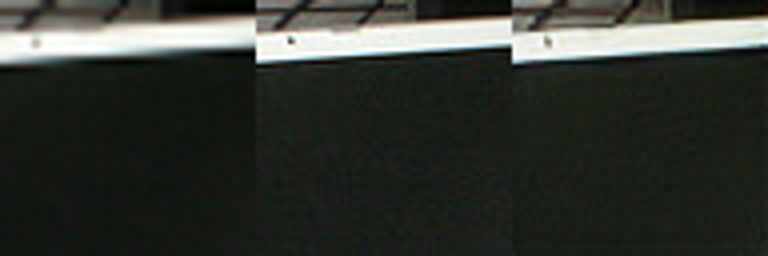

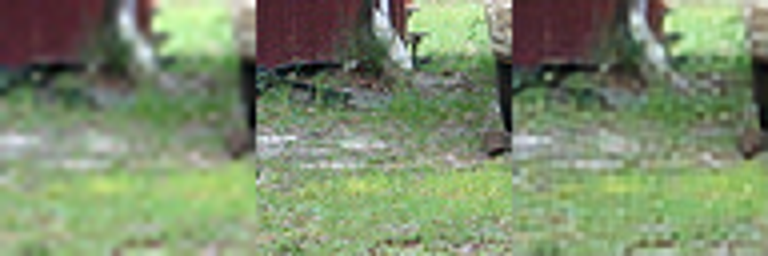

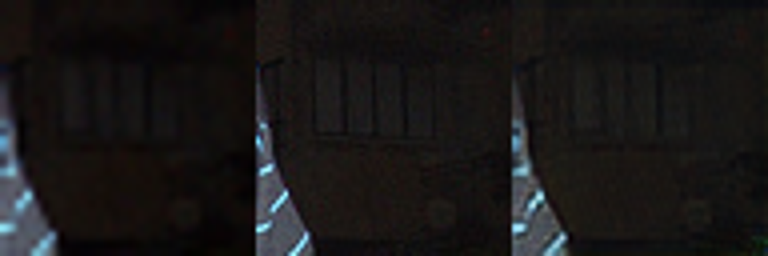

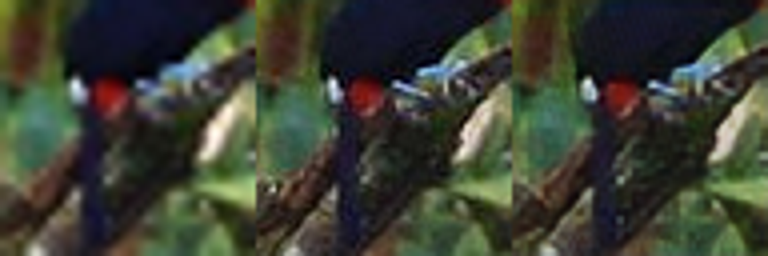

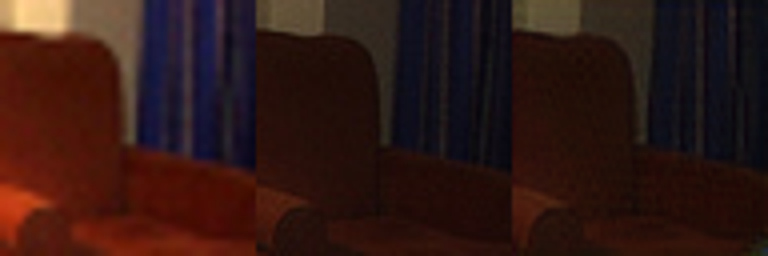

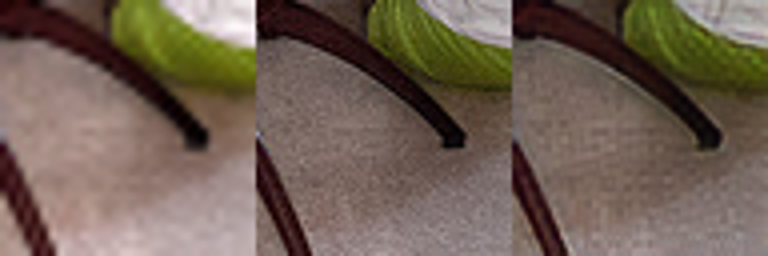

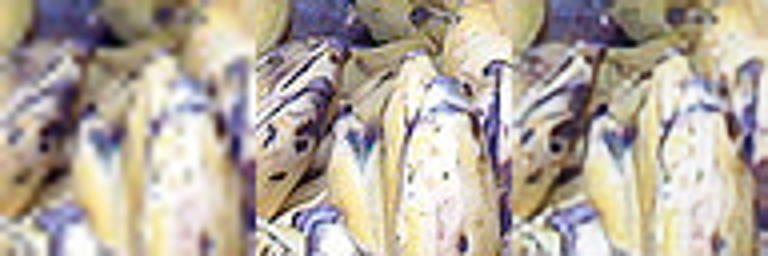

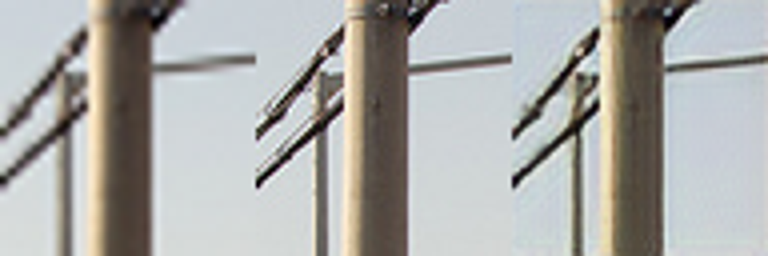

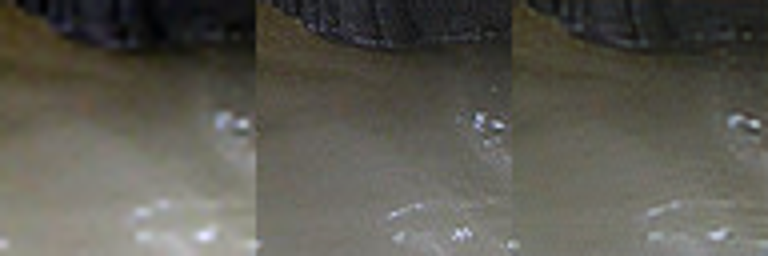

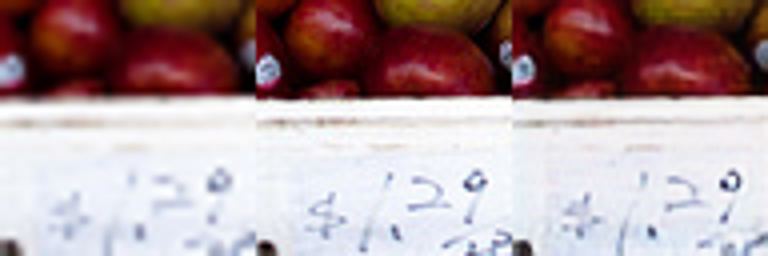

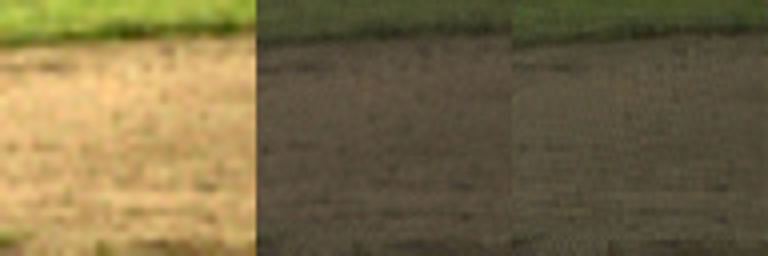

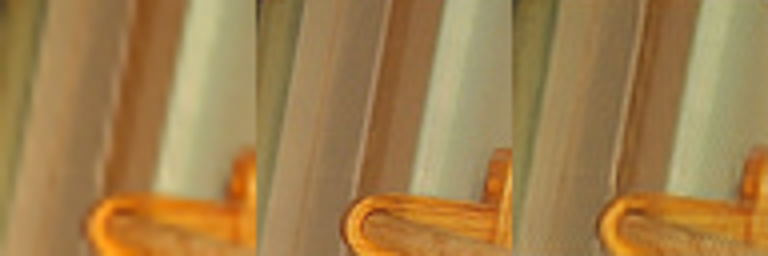

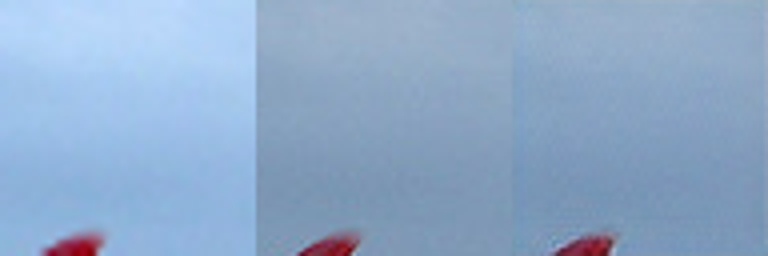

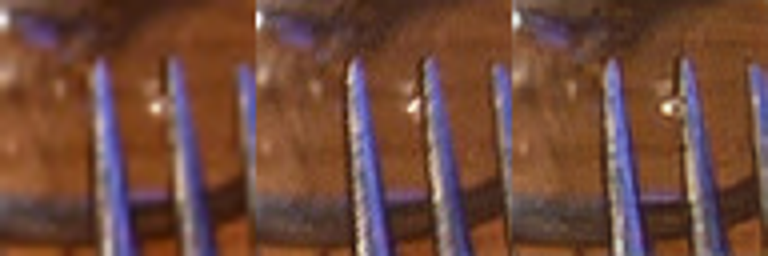

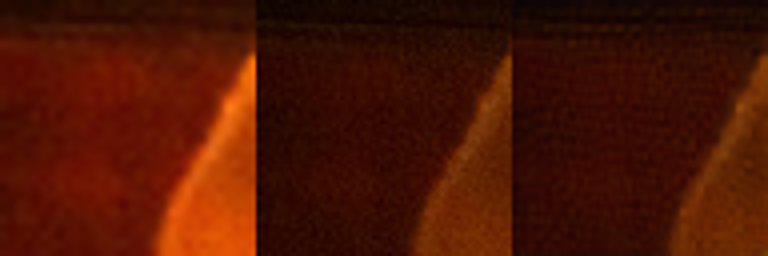

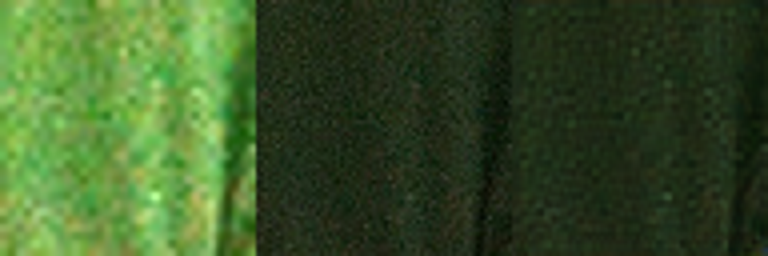

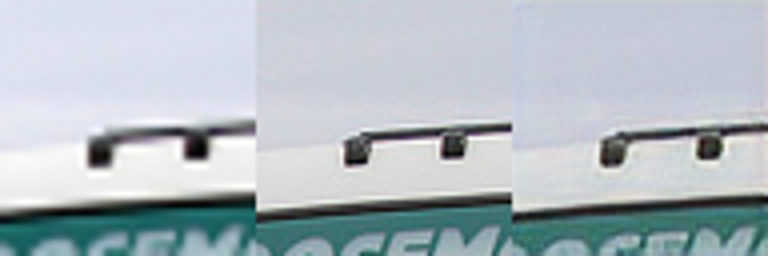

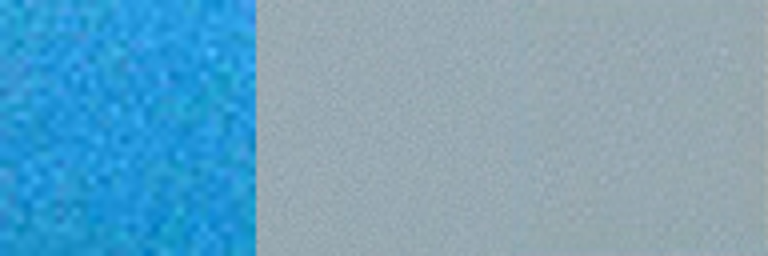

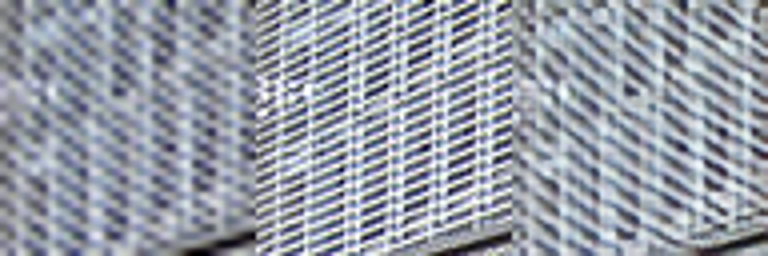

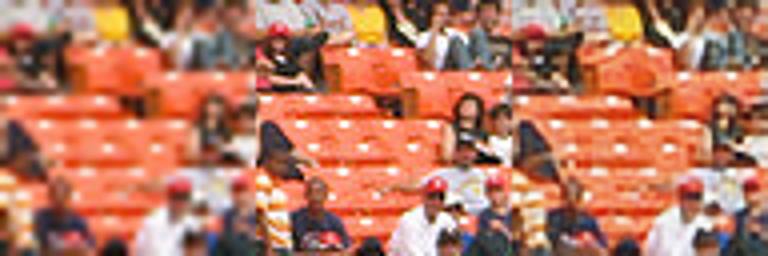

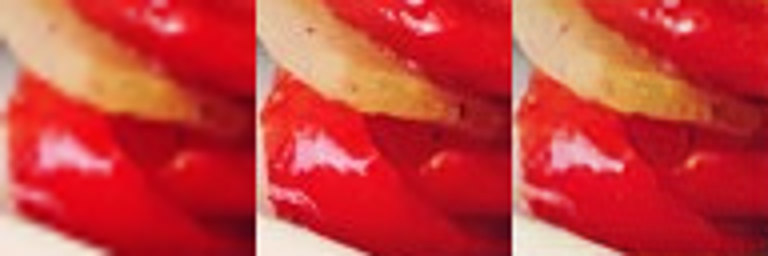

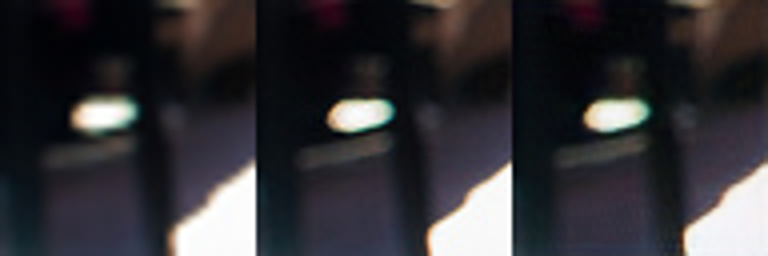

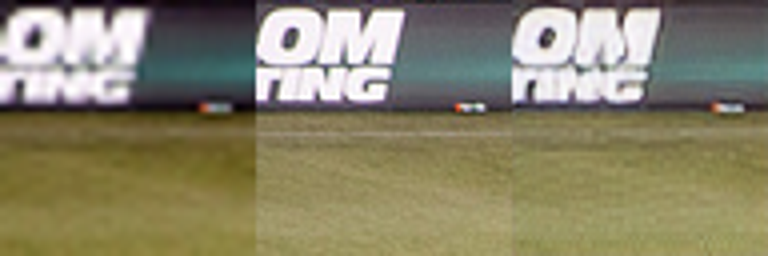

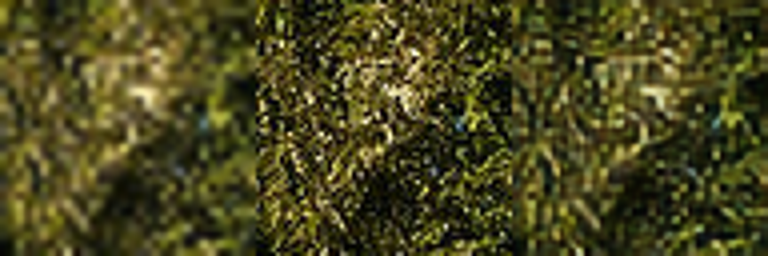

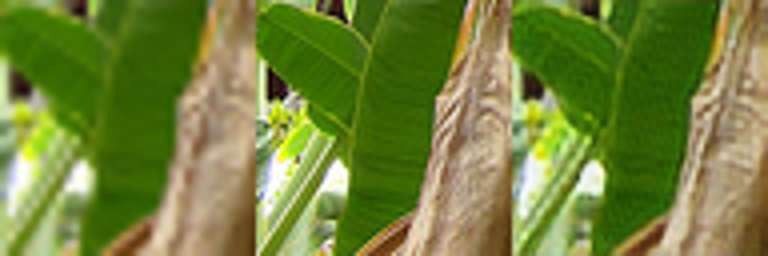

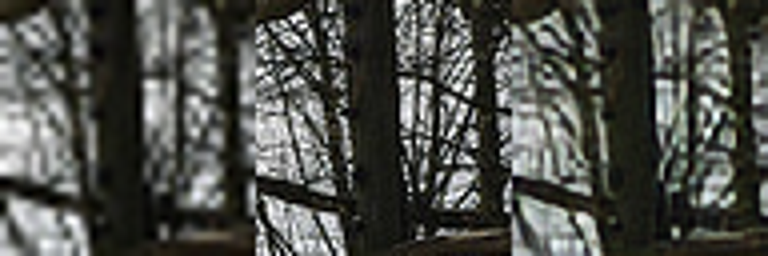

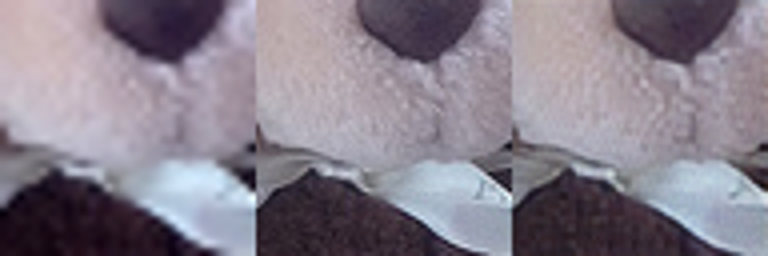

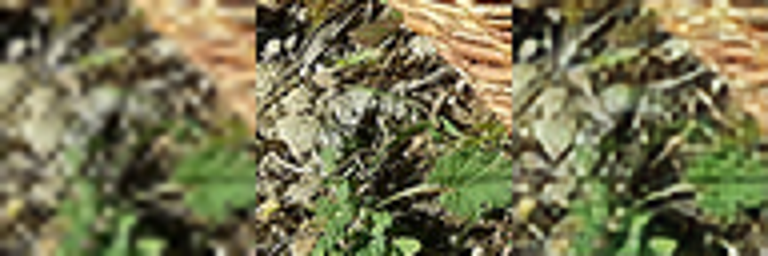

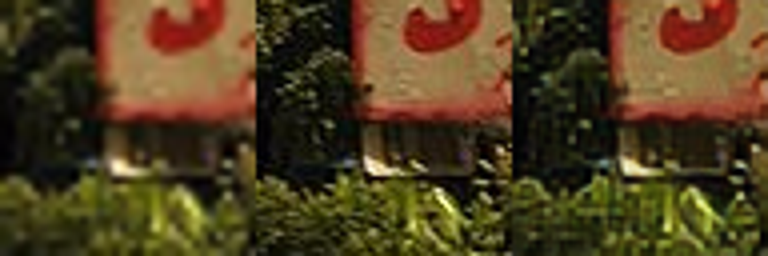

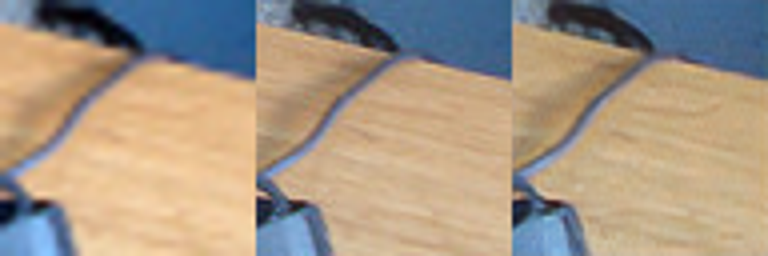

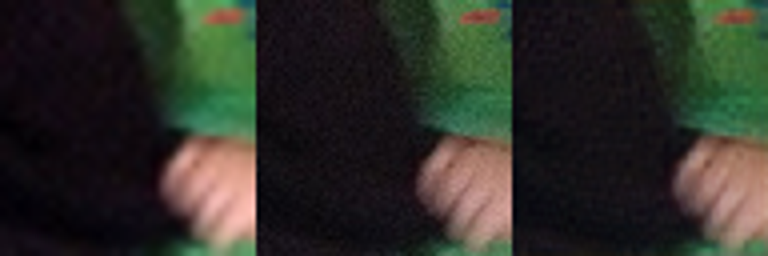

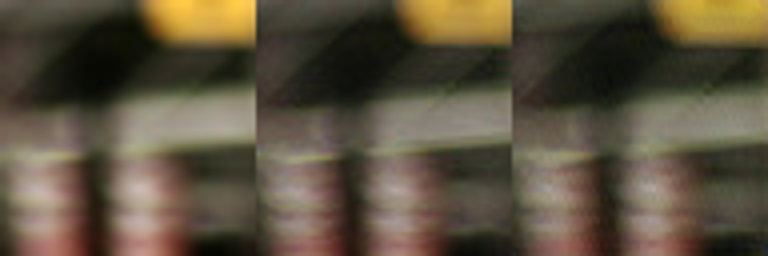

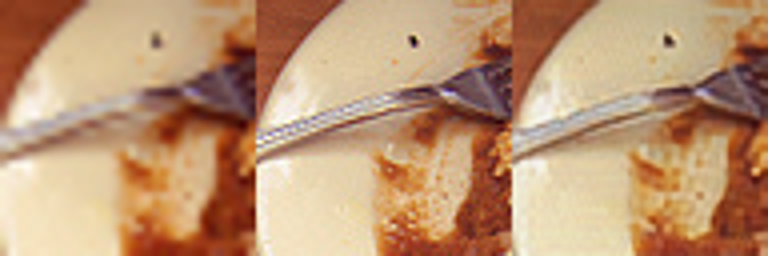

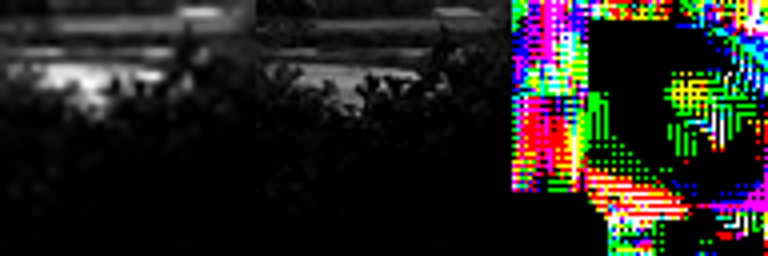

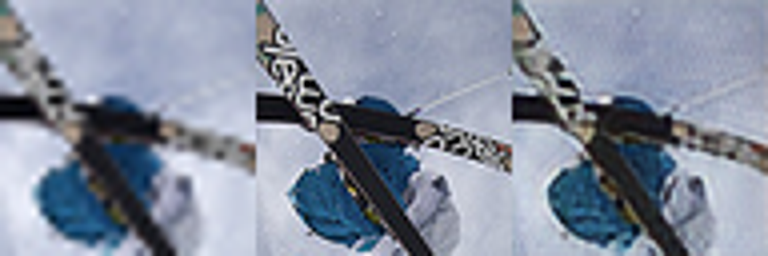

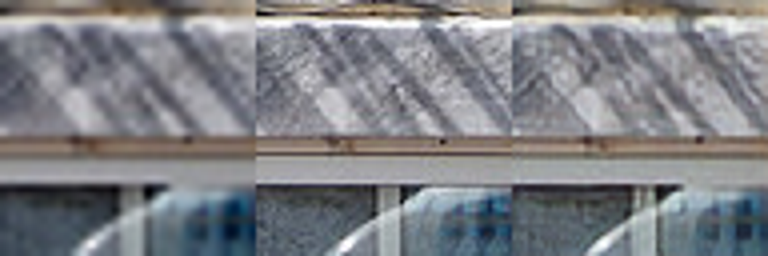

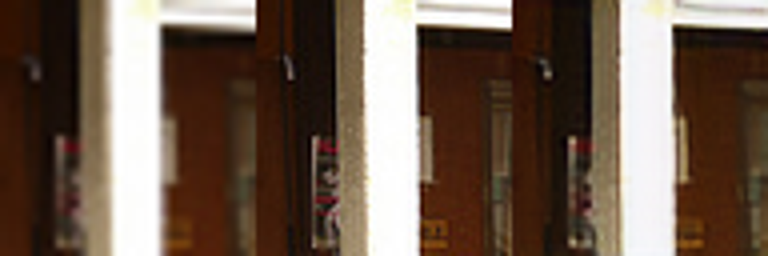

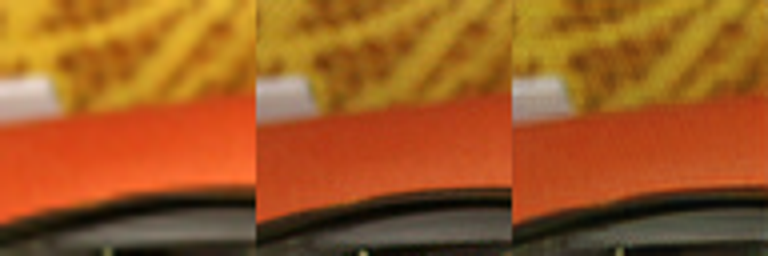

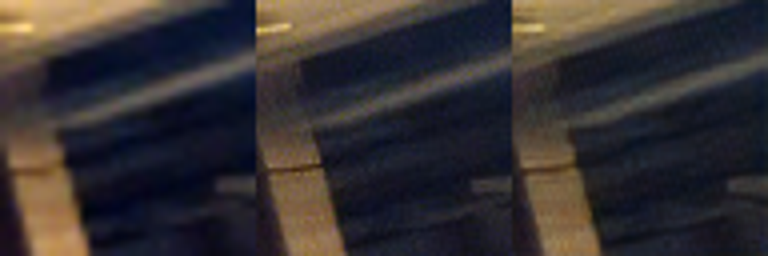

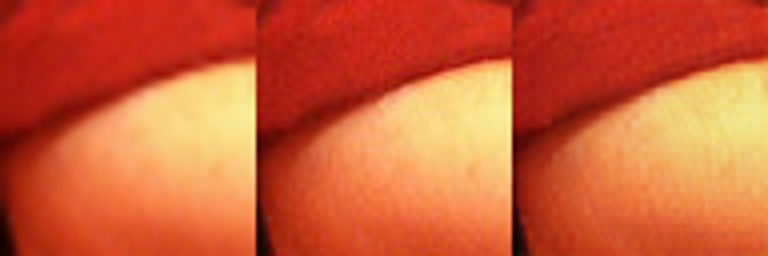

In [ ]:
for j in range(5):
    x, y = test[j]

    y_pred = generator.predict(x)

    x, y, y_pred = x * 255, y * 255, y_pred * 255

    for i in range(8):
        a = img_to_array(array_to_img(x[i]).resize((64,64)))

        a = np.concatenate((a, y[i], y_pred[i]), axis=1)
        a = array_to_img(a).resize((256*3,256))

        display(a)